# Compile usage analytics from a booking calendar

Plot usage stats by user for the year

Usage: 
- Set the list of files and the starting date and run the notebook
- Check if there are no unknown group for the user, edit the users.csv file to update it if needed and run again the notebook. 

In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
from usagestats import data
from pathlib import Path
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

start_date = '2022-11-02' # iso-format data yyyy-mm-dd
num_weeks = 52 # number of weeks to consider
folder = Path('/run/user/1000/gvfs/smb-share:server=istore,share=microscopy_group_share,user=jeromeb/Admin/Usage Stats/2023/')
file_list = [x for x in (folder/'microscope calendars').glob('*.ics')]
instruments_file = folder / 'instruments.csv'
users_file = folder / 'users.csv'
groups_file = folder / 'groups.csv'
bookings_file = folder / 'bookings.csv'
attributes_file = folder / 'attributes.csv'
booking_types = ['service', 'maintenance', 'training']
remove_bookings_type = ['service', 'maintenance']
remove_instrument = ['Analysis pc1','Analysis pc2' ,'Analysis pc3' ,'Analysis pc4','Zeiss sim analysis pc']

## Setting and loading the dataset

In [14]:
instruments = data.load_instruments(file_list)

In [15]:
instruments.sort_values(by='Instrument')

,Instrument,Calendar
21,Analysis pc1,"/run/user/1000/gvfs/smb-share:server=istore,sh..."
14,Analysis pc2,"/run/user/1000/gvfs/smb-share:server=istore,sh..."
11,Analysis pc3,"/run/user/1000/gvfs/smb-share:server=istore,sh..."
8,Analysis pc4,"/run/user/1000/gvfs/smb-share:server=istore,sh..."
9,Andor bc43,"/run/user/1000/gvfs/smb-share:server=istore,sh..."
22,Leica sp8,"/run/user/1000/gvfs/smb-share:server=istore,sh..."
3,Leica sted,"/run/user/1000/gvfs/smb-share:server=istore,sh..."
25,Nanoimager,"/run/user/1000/gvfs/smb-share:server=istore,sh..."
24,Nikon hca,"/run/user/1000/gvfs/smb-share:server=istore,sh..."
2,Nikon isim,"/run/user/1000/gvfs/smb-share:server=istore,sh..."


In [16]:
bookings = data.load_booking(instruments, booking_types)
bookings.head()

,User,Start,End,Subject,Duration,Hours,Type,Instrument
0,Silvia Benito-Kwiecinski,2019-12-13 15:31:00+00:00,2019-12-15 11:01:00+00:00,silvia 2s405,1 days 19:30:00,43.5,standard,Spinning disk
1,Nick Barry,2021-09-14 13:01:00+01:00,2021-09-14 17:01:00+01:00,nick,0 days 04:00:00,4.0,standard,Spinning disk
2,Nick Barry,2019-06-14 14:31:00+01:00,2019-06-14 18:01:00+01:00,nick,0 days 03:30:00,3.5,standard,Spinning disk
3,Ben Ravenhill,2013-10-30 16:31:00+00:00,2013-10-30 19:31:00+00:00,ben r 3s135,0 days 03:00:00,3.0,standard,Spinning disk
4,Isabel Beets,2018-05-25 09:31:00+01:00,2018-05-25 12:01:00+01:00,isabel - 2s439,0 days 02:30:00,2.5,standard,Spinning disk


In [17]:
bookings = data.filter_dates(bookings, start_date, num_weeks)

## Create a list of all users and groups and save it to a file

This also add the Group column to the bookings. At this point, we can edit the user.csv file and run this cell again.

In [19]:
#instruments = pd.DataFrame({"Instrument":bookings["Instrument"].unique()})
users = data.load_users(bookings, users_file)
users.to_csv(users_file, index=False)
print(f'There were {len(users)} unique users on {len(instruments)} instruments')
[x for x in users[users['Group']=='Unknown']['User']]

There are 179 unique users listed in the bookings.
Loading Users and Groups from files /run/user/1000/gvfs/smb-share:server=istore,share=microscopy_group_share,user=jeromeb/Admin/Usage Stats/2023/users.csv
Empty DataFrame
Columns: [User]
Index: []
Number of users without known group: 4
Edit now the /run/user/1000/gvfs/smb-share:server=istore,share=microscopy_group_share,user=jeromeb/Admin/Usage Stats/2023/users.csv to fill out missing groups.
There were 179 unique users on 29 instruments


['Fenja Bahr', 'Nyarie Sithole', 'Alex Kingston', 'Alessa Weiler']

In [20]:
# from the list of users get the list of groups
groups = data.load_groups(users, groups_file)
# save file to disk
groups.to_csv(groups_file,index=False)
#print(f'There are {len(groups)} groups')
groups[groups['Division']=='Unknown']

There are 48 groups in the list of users.
Loading Groups from files groups
Number of unknown division 1
Edit now the /run/user/1000/gvfs/smb-share:server=istore,share=microscopy_group_share,user=jeromeb/Admin/Usage Stats/2023/groups.csv to fill out missing groups.


,Group,Division
48,Unknown,Unknown


## Add group and division to the booking

In [21]:
bookings = pd.merge(bookings, users, left_on='User', right_on='User', how='left')
bookings = pd.merge(bookings, groups, on='Group', how='left')
bookings.head()

,User,Start,End,Subject,Duration,Hours,Type,Instrument,Group,Division
0,Yaiza Andres Jeske,2023-02-16 14:01:00+00:00,2023-02-16 18:01:00+00:00,yaiza 3s409,0 days 04:00:00,4.0,standard,Spinning disk,Bullock,Cell Biology
1,Andrei Mihut,2023-03-15 17:01:00+00:00,2023-03-15 18:01:00+00:00,andrei,0 days 01:00:00,1.0,standard,Spinning disk,O’Neill,Cell Biology
2,Andrei Mihut,2023-07-21 12:01:00+01:00,2023-07-24 08:01:00+01:00,andrei,2 days 20:00:00,68.0,standard,Spinning disk,O’Neill,Cell Biology
3,Anna Edmondson,2023-02-03 11:01:00+00:00,2023-02-03 18:01:00+00:00,anna edmondson dic/brightfield test,0 days 07:00:00,7.0,standard,Spinning disk,O’Neill,Cell Biology
4,Nick Barry,2023-05-23 10:31:00+01:00,2023-05-23 13:01:00+01:00,nick maintenance,0 days 02:30:00,2.5,maintenance,Spinning disk,Light Microscopy,Cell Biology


In [22]:
bookings.to_csv(bookings_file, index=False)

In [55]:
bookings = pd.read_csv(bookings_file)
users = pd.read_csv(users_file)
groups = pd.read_csv(groups_file)

bookings['Start'] = bookings['Start'].transform(data.to_date_time)
bookings['End'] = bookings['End'].transform(data.to_date_time)

## Counts and usage by type of booking

In [56]:
bookings.groupby('Type').agg(Hours=pd.NamedAgg(column="Hours", aggfunc="sum"),
                             Count=pd.NamedAgg(column="Hours", aggfunc="count"))

,Hours,Count
Type,,
maintenance,3548.000000,321
service,829.500000,97
standard,28084.750000,6449
training,477.666667,141


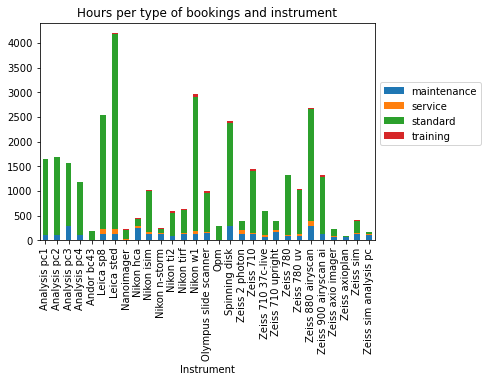

In [57]:
ti = bookings.groupby(['Type','Instrument'],as_index=False).agg(Hours=pd.NamedAgg(column="Hours", aggfunc="sum"),
                                        Count=pd.NamedAgg(column="Hours", aggfunc="count")).pivot('Instrument','Type','Hours')
ti.to_csv(folder / 'booking-by-type-and-instrument.csv')

ti.plot(kind='bar',stacked=True)
plt.legend(bbox_to_anchor=(1,0.75))
plt.title('Hours per type of bookings and instrument')
plt.savefig(folder/'usage-per-type-per-instrument.pdf',pad_inches=1.2,bbox_inches='tight')


## Filter out bookings to eliminate unwanted entries

In [58]:
# excludes special bookings
bookings = bookings[ ~bookings['Type'].isin( remove_bookings_type ) ]
# excludes instruments
bookings = bookings[~bookings.Instrument.isin( remove_instrument )]
bookings.head()

,Unnamed: 0,User,Start,End,Subject,Duration,Hours,Type,Instrument,Group,Division
0,0,Yaiza Andres Jeske,2023-02-16 14:01:00+00:00,2023-02-16 18:01:00+00:00,yaiza 3s409,0 days 04:00:00,4.0,standard,Spinning disk,Bullock,Cell Biology
1,1,Andrei Mihut,2023-03-15 17:01:00+00:00,2023-03-15 18:01:00+00:00,andrei,0 days 01:00:00,1.0,standard,Spinning disk,O’Neill,Cell Biology
2,2,Andrei Mihut,2023-07-21 12:01:00+01:00,2023-07-24 08:01:00+01:00,andrei,2 days 20:00:00,68.0,standard,Spinning disk,O’Neill,Cell Biology
3,3,Anna Edmondson,2023-02-03 11:01:00+00:00,2023-02-03 18:01:00+00:00,anna edmondson dic/brightfield test,0 days 07:00:00,7.0,standard,Spinning disk,O’Neill,Cell Biology
5,5,Ália dos Santos,2023-03-04 18:01:00+00:00,2023-03-05 08:01:00+00:00,alia dos santos,0 days 14:00:00,14.0,standard,Spinning disk,Allegretti,Structural Studies


In [59]:
total_usage_hrs = bookings['Hours'].sum()

info_str = f'\nFrom {datetime.fromisoformat(start_date)} to {datetime.fromisoformat(start_date)+timedelta(weeks=num_weeks)}\nGrand total: {total_usage_hrs:.0f} Hours\n #Users: {len(users)} / #Groups: {len(groups)} / #Instruments: {len(instruments)}'
print(info_str)


From 2022-11-02 00:00:00 to 2023-11-01 00:00:00
Grand total: 23034 Hours
 #Users: 179 / #Groups: 49 / #Instruments: 29


## Usage per groups

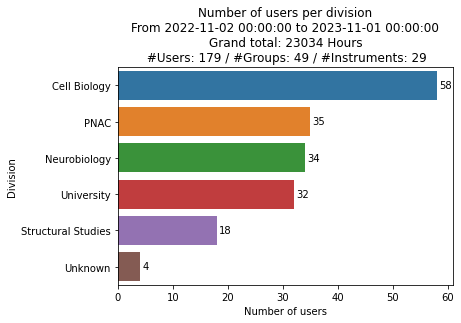

In [60]:
from usagestats import visual
ax = sns.barplot(data=pd.merge(users,groups,on='Group').groupby('Division').count().reset_index().sort_values('User',ascending=False),y='Division',x='User')
visual.show_values_on_bars(ax,'h',hspace=0.4)
plt.xlabel('Number of users')
plt.title('Number of users per division'+info_str)
plt.savefig(folder/'users-per-division.pdf',pad_inches=1.2,bbox_inches='tight')

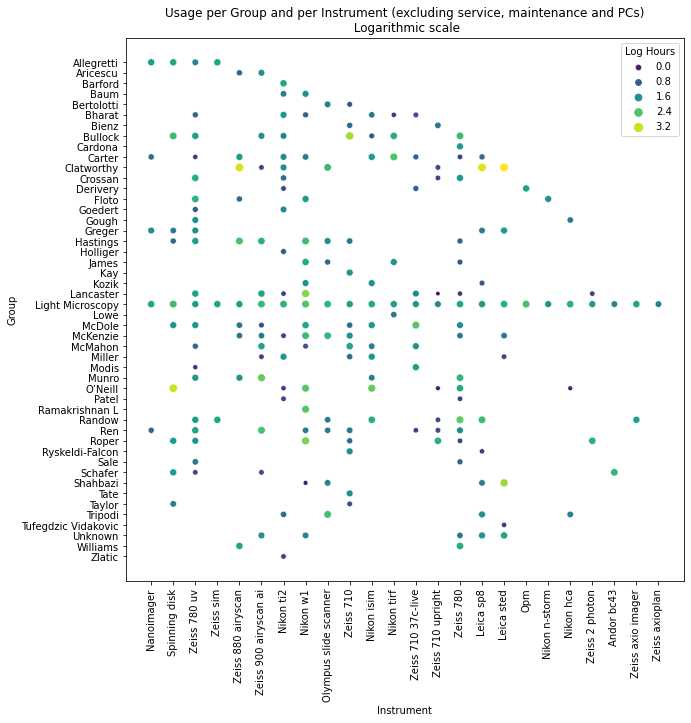

In [61]:
import math
#bookings.groupby(['Group','Instrument'], as_index=False)['Hours'].agg('sum').pivot(index="Group",columns="Instrument",values='Hours').fillna(0).to_csv('usage-per-group-per-instrument.csv')
f,x = plt.subplots(figsize=(10,10))
tmp = bookings.groupby(['Group','Instrument'], as_index=False)['Hours'].agg('sum')
tmp['Hours'] = [math.log10(x) for x in tmp['Hours']]
cmap = sns.color_palette("viridis", as_cmap=True)
#order = tmp.groupby('Group').agg(time=('Hours',sum)).sort_values('time',ascending=False).index.values
sns.scatterplot(data=tmp, x='Instrument', y='Group', size='Hours', hue='Hours',palette=cmap)
plt.xticks(rotation=90)
plt.title('Usage per Group and per Instrument (excluding service, maintenance and PCs)\n Logarithmic scale')
plt.legend(title="Log Hours")
plt.savefig(folder/'usage-per-group-per-instrument.pdf',pad_inches=1.2,bbox_inches='tight')


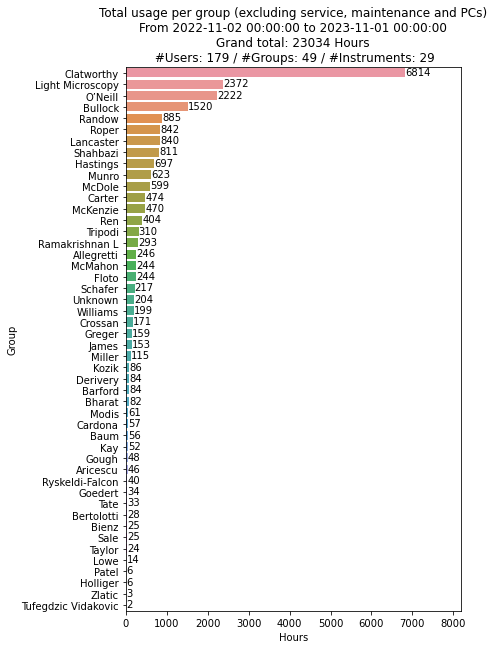

In [62]:
import numpy as np
df = bookings.groupby(['Group'],as_index=False).agg('sum')
grp_order = np.flip(df['Hours'].to_numpy().argsort())
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(data=df,y='Group',x='Hours',order=df['Group'][grp_order])
visual.show_values_on_bars(ax,'h',hspace=0.25)
plt.title(f'Total usage per group (excluding service, maintenance and PCs)'+info_str)
plt.xlim([0, 1.2*df['Hours'].max()])
plt.savefig(folder/'usage-per-group.pdf',pad_inches=1.2,bbox_inches='tight')

## Statistics per division

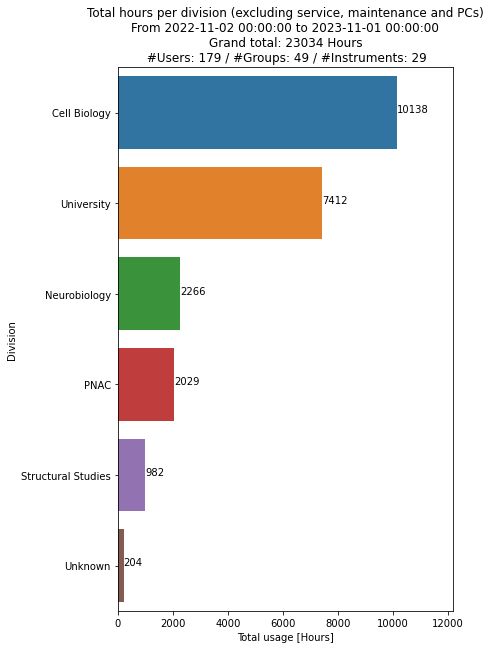

In [63]:
# Sum usage hours per division
per_division = bookings.groupby(['Division'],as_index=False)['Hours'].agg('sum')
grp_order = np.flip(per_division ['Hours'].to_numpy().argsort())
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(data=per_division ,y='Division',x='Hours',order=per_division['Division'][grp_order])
visual.show_values_on_bars(ax,'h')
total_usage_hrs = bookings['Hours'].sum()
plt.title(f'Total hours per division (excluding service, maintenance and PCs)'+info_str)
plt.xlim([0, 1.2*per_division['Hours'].max()])
plt.xlabel('Total usage [Hours]')
plt.savefig(folder/'usage-per-division.pdf',pad_inches=1.2,bbox_inches='tight')

## Compute Usage for each week and each instrument

In [66]:
bookings['Start'][0]
start_date

'2022-11-02'

In [64]:
usage = data.get_usage_by_instrument(bookings, start_date=start_date, num_weeks=num_weeks)

TypeError: Timestamp subtraction must have the same timezones or no timezones

In [67]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=usage[usage['Usage']>0].sort_values('Instrument'),x='Week',y='Instrument',hue='Usage',size='Usage')
plt.legend(bbox_to_anchor=(1,0.7))
plt.title('Usage per week and per instrument (excluding service, maintenance and PCs)'+info_str)
plt.savefig(folder/'usage-per-instrument-per-week-blot.pdf',pad_inches=1.2,bbox_inches='tight')

NameError: name 'usage' is not defined

<Figure size 1440x720 with 0 Axes>

In [ ]:
import numpy as np
# figure for each instruments
plt.figure(figsize=(30,20))
col_order = [*usage['Instrument'].unique()]
col_order.sort()
g = sns.FacetGrid(usage, col="Instrument",col_wrap=4,col_order=col_order)
p = g.map(sns.barplot,"Week","Usage",order=np.arange(num_weeks))
averages = usage.groupby('Instrument')['Usage'].agg(['mean'])
avg_global = averages.mean()[0]

for k, a in enumerate(p.axes):
    mic = a.get_title().replace('Instrument = ','')
    avg = averages['mean'][mic]
    a.set_title(f'{mic} ({avg:.0f}h/w)')
    #a.text(15,130,f'average:{avg:.0f}h/w')
    #a.set_subtitle(f'average:{avg:.0f}h/w')
    a.axhline(avg_global, color='r', linestyle='-')
    a.axhline(avg, color='g', linestyle='-')
    a.set_ylabel('Usage [Hours/Week]')
    a.set_xticks(np.arange(0,num_weeks,step=10))
    a.set_xticklabels(np.arange(0,num_weeks,step=10))
p.fig.subplots_adjust(top=0.9)
p.fig.suptitle('Usage per week and per instrument (excluding service, maintenance and PCs)'+info_str)
plt.savefig(folder/'usage-per-instrument-per-week.pdf')


Save usage to a csv file

In [ ]:
# Save the data in a file
usage.pivot(index="Week",columns="Instrument",values="Usage").to_csv(folder/'usage-per-instrument-per-week.csv')

# Per instrument

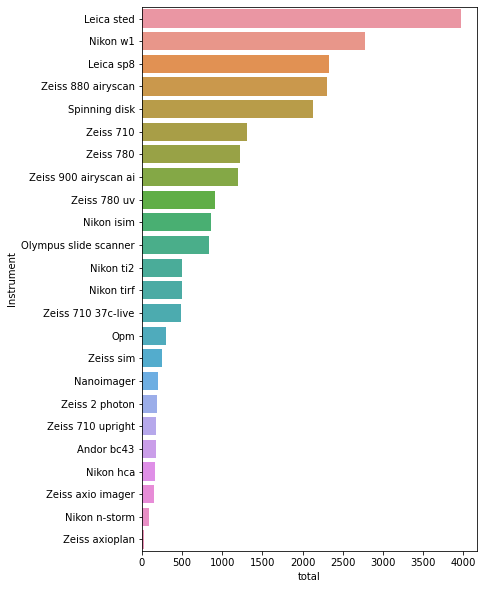

In [68]:
per_inst = bookings.groupby('Instrument',as_index=False).agg(total=('Hours',sum)).sort_values(by='total',ascending=False)
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(data=per_inst, y='Instrument',x='total')
plt.savefig(folder/'usage-per-instrument.pdf')

# Per User

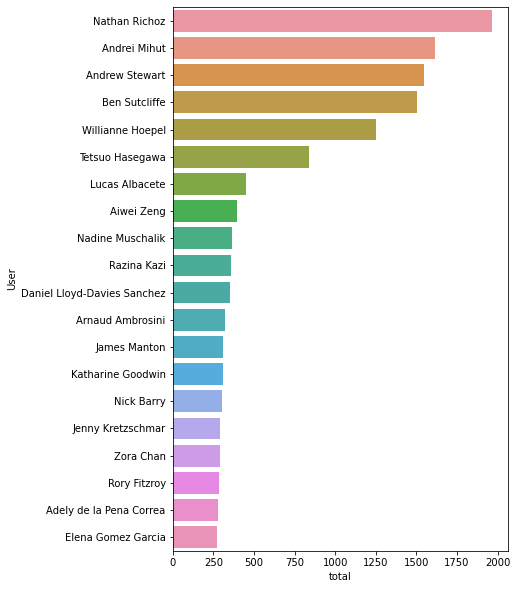

In [69]:
per_user = bookings.groupby('User',as_index=False).agg(total=('Hours',sum)).sort_values(by='total',ascending=False)
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(data=per_user.iloc[0:20], y='User',x='total')
plt.savefig(folder/'user.pdf')

In [ ]:
pd.read_csv(attributes)